In [1]:
# ============================================================
# ✅ FULL END-TO-END RUNNABLE SCRIPT
# Z-CROSS (Train on one PROMISE dataset, Test on another)
# Works with:
#   BASE_PATH = "./../../dataset/"
#   files: pc1.arff, pc2.arff, pc3.arff, pc4.arff (and others)
#
# Includes:
# ✅ build_model + all model classes
# ✅ robust numeric conversion for ARFF
# ✅ robust column alignment by normalized names
# ✅ repeated zcross runs (zcross_repeats=5)
# ✅ SHAP importance (fast_mode supported)
# ✅ Concordance via permutation
# ============================================================

import os, re, random, numpy as np, pandas as pd, shap, matplotlib.pyplot as plt, warnings
from dataclasses import dataclass
from typing import Optional, List, Tuple, Dict
from scipy.io import arff
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from scipy.stats import spearmanr

warnings.filterwarnings("ignore")
pd.set_option("display.float_format", lambda x: f"{x:.3f}")

try:
    from xgboost import XGBClassifier
except Exception:
    XGBClassifier = None
try:
    from lightgbm import LGBMClassifier
except Exception:
    LGBMClassifier = None
try:
    from catboost import CatBoostClassifier
except Exception:
    CatBoostClassifier = None

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader


# ============================================================
# ✅ SET YOUR DATASET DIRECTORY HERE
# ============================================================
BASE_PATH = "/content/"


# ============================================================
# Helpers
# ============================================================
def set_seed(s: Optional[int]):
    if s is None: return
    random.seed(s)
    np.random.seed(s)
    os.environ["PYTHONHASHSEED"] = str(s)
    torch.manual_seed(s)

def drop_constant_and_fillna(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    bad = [c for c in X.columns if X[c].nunique(dropna=False) <= 1]
    if bad:
        X.drop(columns=bad, inplace=True)
    if X.isna().any().any():
        X = X.fillna(method="ffill").fillna(method="bfill")
    return X

def _to_float32(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in df.columns:
        if pd.api.types.is_float_dtype(df[c]):
            df[c] = df[c].astype(np.float32)
    return df

def spearman_rank_corr(a: pd.Series, b: pd.Series) -> float:
    a, b = a.align(b, join="inner")
    return spearmanr(a.values, b.values).correlation if len(a) else np.nan

def rescale01_rho(rho: float) -> float:
    return np.nan if np.isnan(rho) else 0.5 * (rho + 1)

def _decode_bytes_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in df.columns:
        if df[c].dtype == object and len(df[c]) > 0 and isinstance(df[c].iloc[0], (bytes, bytearray)):
            df[c] = df[c].apply(lambda x: x.decode("utf-8", "ignore") if isinstance(x, (bytes, bytearray)) else x)
    return df

def _binarize_target(y: pd.Series) -> pd.Series:
    y = y.copy()
    if pd.api.types.is_numeric_dtype(y):
        uniq = pd.unique(y)
        if len(uniq) > 2:
            return (y.astype(float) > 0).astype(int)
        vals = set(pd.unique(y))
        if vals.issubset({0, 1}):
            return y.astype(int)
        if vals.issubset({1, 2}):
            return (y.astype(int) == 2).astype(int)
        return (y.astype(float) > 0).astype(int)

    y_ = y.astype(str).str.strip().str.lower()
    truthy = {"true", "y", "yes", "defect", "defects", "bug", "bugs", "t", "1"}
    falsy  = {"false", "n", "no", "clean", "f", "0"}
    return y_.apply(lambda v: 1 if (v in truthy) else (0 if v in falsy else (1 if v not in falsy else 0))).astype(int)

def _ensure_df(X, cols: List[str]) -> pd.DataFrame:
    if isinstance(X, pd.DataFrame):
        return X[cols] if list(X.columns) != list(cols) else X
    return pd.DataFrame(np.asarray(X), columns=cols)

def _mean_abs_by_feature(sv, n_features: int) -> np.ndarray:
    if isinstance(sv, list):
        arr = np.asarray(sv[1] if len(sv) >= 2 else sv[0])
    else:
        arr = np.asarray(sv)

    if arr.ndim == 2 and arr.shape[1] == n_features:
        return np.abs(arr).mean(axis=0)

    feat_axes = [ax for ax, d in enumerate(arr.shape) if d == n_features]
    if feat_axes:
        arr = np.moveaxis(arr, feat_axes[0], -1)
        return np.abs(arr).mean(axis=tuple(range(arr.ndim - 1)))

    return np.abs(arr.reshape(-1, n_features)).mean(axis=0)


import re
from typing import Dict, List, Tuple

def _canon(c: str) -> str:
    """Canonical key for matching: uppercase, underscores, drop spaces."""
    return re.sub(r"\s+", "", str(c).strip()).upper()

# -----------------------------
# Metric-family mapping (PC1-style ↔ PC2/PC3/PC4-style)
# -----------------------------
PC1_TO_NASA_MAP = {
    "loc": "LOC_EXECUTABLE",
    "lOComment": "LOC_COMMENTS",
    "locCodeAndComment": "LOC_CODE_AND_COMMENT",
    "v(g)": "CYCLOMATIC_COMPLEXITY",
    "iv(G)": "DESIGN_COMPLEXITY",
    "ev(g)": "ESSENTIAL_COMPLEXITY",
    # Halstead-ish (PC2/3/4 often have these)
    "D": "HALSTEAD_DIFFICULTY",
    "E": "HALSTEAD_EFFORT",
    "I": "HALSTEAD_CONTENT",
    # best-effort matches (may or may not exist depending on PC2/3/4)
    "B": "HALSTEAD_ERROR_EST",
}

# build reverse mapping automatically
NASA_TO_PC1_MAP = {v: k for k, v in PC1_TO_NASA_MAP.items()}

def align_train_test_features_auto(
    Xtr: pd.DataFrame,
    Xte: pd.DataFrame,
    min_common: int = 5
) -> Tuple[pd.DataFrame, pd.DataFrame, List[str], str]:
    """
    Try in order:
    1) Direct exact intersection
    2) Mapping PC1->NASA
    3) Mapping NASA->PC1
    Returns aligned (Xtr_aligned, Xte_aligned, common_cols, mode)
    """

    Xtr = Xtr.copy()
    Xte = Xte.copy()

    # ----- (1) exact intersection -----
    common_exact = sorted(list(set(Xtr.columns).intersection(set(Xte.columns))))
    if len(common_exact) >= min_common:
        return Xtr[common_exact].copy(), Xte[common_exact].copy(), common_exact, "EXACT"

    # canonical maps for lookup
    tr_map = {_canon(c): c for c in Xtr.columns}
    te_map = {_canon(c): c for c in Xte.columns}

    # helper: apply a mapping dict where keys refer to train, values refer to test
    def _apply_mapping(map_dict: Dict[str, str], mode_name: str):
        tr_sel, te_sel, names = [], [], []
        for tr_name, te_name in map_dict.items():
            tr_key = _canon(tr_name)
            te_key = _canon(te_name)
            if tr_key in tr_map and te_key in te_map:
                tr_sel.append(tr_map[tr_key])
                te_sel.append(te_map[te_key])
                names.append(f"{tr_name}__to__{te_name}")
        if len(names) >= 3:  # minimum to be meaningful
            Xt = Xtr[tr_sel].copy()
            Xe = Xte[te_sel].copy()
            Xt.columns = names
            Xe.columns = names
            return Xt, Xe, names, mode_name
        return None

    # ----- (2) PC1 -> NASA mapping -----
    out = _apply_mapping(PC1_TO_NASA_MAP, "MAP_PC1_TO_NASA")
    if out is not None:
        return out

    # ----- (3) NASA -> PC1 mapping -----
    out = _apply_mapping(NASA_TO_PC1_MAP, "MAP_NASA_TO_PC1")
    if out is not None:
        return out

    # debugging output
    print("DEBUG: exact common =", len(common_exact))
    print("DEBUG: train cols sample:", list(Xtr.columns)[:20])
    print("DEBUG: test cols sample :", list(Xte.columns)[:20])

    raise ValueError("No common features (no exact match and mapping failed).")

# ============================================================
# ✅ PATCH: Robust numeric extraction
# ============================================================
def to_numeric_features_only(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [str(c).strip() for c in df.columns]

    for c in df.columns:
        if df[c].dtype == object:
            df[c] = df[c].apply(lambda x: x.decode("utf-8", "ignore") if isinstance(x, (bytes, bytearray)) else x)
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.dropna(axis=1, how="all")
    return df


# ============================================================
# ✅ Config
# ============================================================
@dataclass
class PipelineConfig:
    target_col: Optional[str] = None
    rng: int = 42

    # Z-cross repeated fits to mimic 5 folds
    zcross_repeats: int = 5
    use_smote: bool = True
    smote_k_max: int = 5

    # SHAP
    shap_background_size: int = 1024
    shap_eval_size: int = 6000
    shap_nsamples: int = 200
    shap_mode: str = "auto"
    fast_mode: bool = True
    fast_shap_k: int = 64

    # Concordance
    perm_repeats: int = 15
    perm_max_features: Optional[int] = None
    concordance_top_k: int = 25

    # Model params
    rf_n_estimators: int = 400
    rf_max_depth: Optional[int] = 12
    rf_min_samples_leaf: int = 3


# ============================================================
# Dataset loading
# ============================================================
TARGET_CANDIDATES = ["Defective","defective","defects","bug","bugs","class","label","target","c"]

def _resolve_dataset(dataset: str) -> Tuple[str, Optional[str]]:
    ds = dataset.strip()

    if os.path.exists(ds):
        return ds, None

    candidate = os.path.join(BASE_PATH, ds)
    if os.path.exists(candidate):
        return candidate, None

    alias_map = {"PC1":"pc1.arff","PC2":"pc2.arff","PC3":"pc3.arff","PC4":"pc4.arff",
                 "MC1":"mc1.arff","MC2":"mc2.arff","MW1":"mw1.arff","CM1":"CM1.csv"}
    key = ds.upper()
    if key in alias_map:
        p = os.path.join(BASE_PATH, alias_map[key])
        return p, ("Defective" if key == "CM1" else None)

    raise FileNotFoundError(f"Dataset '{dataset}' not found under {BASE_PATH}")

def _read_arff(path: str) -> pd.DataFrame:
    data, meta = arff.loadarff(path)
    df = pd.DataFrame(data)
    return _decode_bytes_cols(df)

def _read_csv(path: str) -> pd.DataFrame:
    return pd.read_csv(path)

def _auto_find_target(df: pd.DataFrame, hint: Optional[str]) -> str:
    if hint and hint in df.columns:
        return hint
    lowmap = {c.lower(): c for c in df.columns}
    for k in TARGET_CANDIDATES:
        if k.lower() in lowmap:
            return lowmap[k.lower()]
    return df.columns[-1]

def load_dataset(dataset: str, target_col: Optional[str] = None) -> Tuple[pd.DataFrame, pd.Series]:
    path, suggested = _resolve_dataset(dataset)
    ext = os.path.splitext(path)[1].lower()
    if ext == ".arff":
        df = _read_arff(path)
    elif ext == ".csv":
        df = _read_csv(path)
    else:
        raise ValueError(f"Unsupported: {ext}")

    tgt = target_col or _auto_find_target(df, suggested)
    y = _binarize_target(df[tgt].copy())
    X = to_numeric_features_only(df.drop(columns=[tgt]).copy())
    return X, y

# ============================================================
# ✅ Models + build_model (NOW INCLUDED)
# ============================================================
class BaseModel:
    def __init__(self, cfg: PipelineConfig, random_state: int):
        self.cfg = cfg
        self._cols: List[str] = []

    def fit(self, X: pd.DataFrame, y: pd.Series): raise NotImplementedError
    def predict_proba(self, X: pd.DataFrame) -> np.ndarray: raise NotImplementedError
    def shap_importance(self, X_bg: pd.DataFrame, X_eval: pd.DataFrame) -> pd.Series: raise NotImplementedError

class SklearnTreeLike(BaseModel):
    def __init__(self, estimator, cfg: PipelineConfig, random_state: int):
        super().__init__(cfg, random_state)
        self.model = estimator

    def fit(self, X: pd.DataFrame, y: pd.Series):
        X = _to_float32(X)
        self._cols = list(X.columns)
        self.model.fit(X[self._cols], y)
        return self

    def predict_proba(self, X: pd.DataFrame) -> np.ndarray:
        X = _ensure_df(X, self._cols)
        X = _to_float32(X)
        return self.model.predict_proba(X[self._cols])

    def shap_importance(self, X_bg: pd.DataFrame, X_eval: pd.DataFrame) -> pd.Series:
        if getattr(self.cfg, "shap_mode", "auto") == "disable":
            return pd.Series(dtype=float)

        cols = self._cols
        rng = np.random.RandomState(0)

        k = min(self.cfg.fast_shap_k, max(1, len(X_bg))) if self.cfg.fast_mode else min(256, max(1, min(len(X_bg), self.cfg.shap_background_size)))
        bg = X_bg.copy()
        if len(bg) > k:
            bg = bg.iloc[rng.choice(len(bg), size=k, replace=False)]

        X_eval = _ensure_df(X_eval, cols)
        if len(X_eval) > self.cfg.shap_eval_size:
            X_eval = X_eval.iloc[rng.choice(len(X_eval), size=self.cfg.shap_eval_size, replace=False)]

        try:
            expl = shap.TreeExplainer(self.model, data=bg, feature_perturbation="tree_path_dependent", model_output="probability")
            sv = expl.shap_values(X_eval, check_additivity=False)
        except Exception:
            # fallback KernelExplainer
            def f_np(Z):
                Z = _ensure_df(Z, cols)
                return self.predict_proba(Z)[:, 1]
            expl = shap.KernelExplainer(f_np, bg, link="identity")
            sv = expl.shap_values(X_eval, nsamples=self.cfg.shap_nsamples)

        imp_vec = _mean_abs_by_feature(sv, n_features=len(cols))
        return pd.Series(imp_vec, index=cols, name="mean|SHAP|")

class RandomForestModel(SklearnTreeLike):
    def __init__(self, cfg: PipelineConfig, random_state: int):
        est = RandomForestClassifier(
            n_estimators=cfg.rf_n_estimators,
            max_depth=cfg.rf_max_depth,
            min_samples_leaf=cfg.rf_min_samples_leaf,
            random_state=random_state,
            n_jobs=-1,
            class_weight="balanced_subsample",
        )
        super().__init__(est, cfg, random_state)

class ExtraTreesModel(SklearnTreeLike):
    def __init__(self, cfg: PipelineConfig, random_state: int):
        est = ExtraTreesClassifier(
            n_estimators=cfg.rf_n_estimators,
            max_depth=cfg.rf_max_depth,
            min_samples_leaf=cfg.rf_min_samples_leaf,
            random_state=random_state,
            n_jobs=-1,
            class_weight="balanced_subsample",
        )
        super().__init__(est, cfg, random_state)

class GradientBoostingModel(SklearnTreeLike):
    def __init__(self, cfg: PipelineConfig, random_state: int):
        est = GradientBoostingClassifier(
            n_estimators=300, learning_rate=0.05, max_depth=3, random_state=random_state
        )
        super().__init__(est, cfg, random_state)

class AdaBoostModel(SklearnTreeLike):
    def __init__(self, cfg: PipelineConfig, random_state: int):
        est = AdaBoostClassifier(
            n_estimators=300, learning_rate=0.05, random_state=random_state
        )
        super().__init__(est, cfg, random_state)

class XGBModel(SklearnTreeLike):
    def __init__(self, cfg: PipelineConfig, random_state: int):
        if XGBClassifier is None:
            raise ImportError("xgboost not installed")
        est = XGBClassifier(
            n_estimators=400, max_depth=6, learning_rate=0.05,
            subsample=0.9, colsample_bytree=0.9,
            eval_metric="logloss", random_state=random_state, n_jobs=-1
        )
        super().__init__(est, cfg, random_state)

class LGBMModel(SklearnTreeLike):
    def __init__(self, cfg: PipelineConfig, random_state: int):
        if LGBMClassifier is None:
            raise ImportError("lightgbm not installed")
        est = LGBMClassifier(
            n_estimators=500, learning_rate=0.05,
            subsample=0.9, colsample_bytree=0.9,
            random_state=random_state, n_jobs=-1,
            class_weight="balanced"
        )
        super().__init__(est, cfg, random_state)

class CatBoostModel(SklearnTreeLike):
    def __init__(self, cfg: PipelineConfig, random_state: int):
        if CatBoostClassifier is None:
            raise ImportError("catboost not installed")
        est = CatBoostClassifier(
            iterations=500, depth=6, learning_rate=0.05,
            loss_function="Logloss", verbose=False, random_state=random_state,
            auto_class_weights="Balanced"
        )
        super().__init__(est, cfg, random_state)

class TorchMLP(nn.Module):
    def __init__(self, d_in: int, hidden: int = 128, layers: int = 2, dropout: float = 0.15):
        super().__init__()
        blocks = []
        d = d_in
        for _ in range(layers):
            blocks += [nn.Linear(d, hidden), nn.ReLU(inplace=True), nn.Dropout(dropout)]
            d = hidden
        blocks += [nn.Linear(d, 1)]
        self.net = nn.Sequential(*blocks)

    def forward(self, x):
        return self.net(x).squeeze(1)

class MLPModel(BaseModel):
    def __init__(self, cfg: PipelineConfig, random_state: int):
        super().__init__(cfg, random_state)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = None

    def fit(self, X: pd.DataFrame, y: pd.Series):
        X = _to_float32(X)
        self._cols = list(X.columns)

        Xv = torch.tensor(X[self._cols].values, dtype=torch.float32)
        yv = torch.tensor(y.values.astype(np.float32), dtype=torch.float32)
        ds = TensorDataset(Xv, yv)
        dl = DataLoader(ds, batch_size=512, shuffle=True, drop_last=False)

        self.model = TorchMLP(d_in=Xv.shape[1]).to(self.device)
        opt = torch.optim.Adam(self.model.parameters(), lr=1e-3, weight_decay=1e-5)

        for _ in range(15):
            self.model.train()
            for xb, yb in dl:
                xb = xb.to(self.device)
                yb = yb.to(self.device)
                logits = self.model(xb)
                loss = F.binary_cross_entropy_with_logits(logits, yb)
                opt.zero_grad()
                loss.backward()
                opt.step()
        return self

    def predict_proba(self, X: pd.DataFrame) -> np.ndarray:
        X = _ensure_df(X, self._cols)
        X = _to_float32(X)
        xv = torch.tensor(X[self._cols].values, dtype=torch.float32).to(self.device)
        self.model.eval()
        with torch.no_grad():
            p = torch.sigmoid(self.model(xv)).cpu().numpy()
        p = np.clip(p, 1e-6, 1-1e-6)
        return np.c_[1-p, p]

    def shap_importance(self, X_bg: pd.DataFrame, X_eval: pd.DataFrame) -> pd.Series:
        # (Optional) expensive; disable if needed
        return pd.Series(dtype=float)

def build_model(model_name: str, cfg: PipelineConfig, random_state: int) -> BaseModel:
    name = model_name.strip().lower()
    if name in ("rf","random_forest","random-forest"):
        return RandomForestModel(cfg, random_state)
    if name in ("et","extra_trees","extratrees"):
        return ExtraTreesModel(cfg, random_state)
    if name in ("gb","gbrt","gradient_boosting"):
        return GradientBoostingModel(cfg, random_state)
    if name in ("ada","adaboost"):
        return AdaBoostModel(cfg, random_state)
    if name in ("xgb","xgboost"):
        return XGBModel(cfg, random_state)
    if name in ("lgb","lgbm","lightgbm"):
        return LGBMModel(cfg, random_state)
    if name in ("cb","catboost"):
        return CatBoostModel(cfg, random_state)
    if name in ("mlp","nn"):
        return MLPModel(cfg, random_state)
    raise ValueError("Unknown model_name")


def compute_train_shap_for_gen(model, Xfit: pd.DataFrame, Xtrain: pd.DataFrame,
                               cfg: PipelineConfig, seed: int) -> pd.Series:
    """
    Compute mean|SHAP| on a TRAIN subset for Generalizability.
    Train-only background (Xfit), eval on a subset of Xtrain (fast + no leakage).
    """
    if getattr(cfg, "shap_mode", "auto") == "disable":
        return pd.Series(dtype=float)

    rng = np.random.RandomState(seed)
    Xtrain_eval = Xtrain.copy()

    # keep it fast
    max_eval = min(len(Xtrain_eval), 1200 if cfg.fast_mode else cfg.shap_eval_size)
    if len(Xtrain_eval) > max_eval:
        Xtrain_eval = Xtrain_eval.iloc[rng.choice(len(Xtrain_eval), size=max_eval, replace=False)]

    return model.shap_importance(Xfit, Xtrain_eval)


def concordance_shap_vs_permutation(model, X_test: pd.DataFrame, y_test: pd.Series, p_te: np.ndarray,
                                    g_te: pd.Series, cfg: PipelineConfig, seed: int) -> float:
    """
    Concordance between SHAP ranking and permutation-importance ranking on TEST.
    Returns Spearman rho on the overlap of top-K features.
    """
    if g_te is None or g_te.empty:
        return np.nan

    K = min(cfg.concordance_top_k, len(g_te))
    top_shap = g_te.sort_values(ascending=False).head(K).index.tolist()
    perm_pool = top_shap if cfg.perm_max_features is None else top_shap[:cfg.perm_max_features]
    if len(perm_pool) == 0:
        return np.nan

    base_auc = roc_auc_score(y_test, p_te)
    rng0 = np.random.RandomState(1000 + seed)
    rsum = np.zeros(len(perm_pool), dtype=np.float32)

    for _ in range(cfg.perm_repeats):
        Xp = X_test.copy()
        deltas = []
        for c in perm_pool:
            Xp[c] = rng0.permutation(Xp[c].values)
            auc_p = roc_auc_score(y_test, model.predict_proba(Xp)[:, 1])
            deltas.append(max(base_auc - auc_p, 0.0))
            Xp[c] = X_test[c].values
        ranks = pd.Series(deltas, index=perm_pool).rank(pct=True)
        rsum += ranks.values

    perm_rank = pd.Series(rsum / max(1, cfg.perm_repeats), index=perm_pool)
    g_rank = g_te.rank(pct=True)
    perm_rank = perm_rank.rank(pct=True)

    # overlap of top-K sets
    top_overlap = list(set(g_rank.sort_values(ascending=False).head(K).index) &
                       set(perm_rank.sort_values(ascending=False).head(K).index))
    if not top_overlap:
        return np.nan

    return spearman_rank_corr(g_rank.loc[top_overlap], perm_rank.loc[top_overlap])


# ============================================================
# Z-CROSS Reliability
# ============================================================
def run_reliability_zcross(
    X_train: pd.DataFrame, y_train: pd.Series,
    X_test: pd.DataFrame,  y_test: pd.Series,
    cfg: PipelineConfig, model_name: str,
):
    set_seed(cfg.rng)

    # clean + float
    X_train = _to_float32(drop_constant_and_fillna(X_train))
    X_test  = _to_float32(drop_constant_and_fillna(X_test))

    # align features
    X_train, X_test, cols, mode = align_train_test_features_auto(X_train, X_test, min_common=5)
    print(f"[ALIGN:{mode}] common_features={len(cols)}")

    rows = []
    test_expls = []

    for rep in range(1, cfg.zcross_repeats + 1):
        seed = cfg.rng + rep
        set_seed(seed)

        # SMOTE only on TRAIN (no leakage)
        Xfit, yfit = X_train, y_train
        if cfg.use_smote:
            try:
                minority = int((y_train == 1).sum())
                k = min(cfg.smote_k_max, max(1, minority - 1))
                Xfit, yfit = SMOTE(random_state=seed, k_neighbors=k).fit_resample(X_train, y_train)
            except Exception:
                pass

        model = build_model(model_name, cfg, random_state=seed).fit(Xfit, yfit)

        # train metrics on original train
        p_tr = model.predict_proba(X_train)[:, 1]
        yhat_tr = (p_tr >= 0.5).astype(int)

        # test metrics (Z-cross)
        p_te = model.predict_proba(X_test)[:, 1]
        yhat_te = (p_te >= 0.5).astype(int)

        train_auc = roc_auc_score(y_train, p_tr)
        test_auc  = roc_auc_score(y_test,  p_te)

        # ---- SHAP on TEST (train background only) ----
        g_te = model.shap_importance(Xfit, X_test)
        test_expls.append(g_te)

        # ✅ FIX: Generalizability must compare TRAIN vs TEST explanations
        gen = np.nan
        if g_te is not None and not g_te.empty:
            g_tr = compute_train_shap_for_gen(model, Xfit, X_train, cfg, seed=seed)
            gen = spearman_rank_corr(g_tr, g_te)

        # ✅ Concordance (SHAP vs permutation on TEST)
        conc = concordance_shap_vs_permutation(model, X_test, y_test, p_te, g_te, cfg, seed=seed)

        rows.append({
            "rep": rep,
            "Train_AUC": train_auc,
            "Train_F1": f1_score(y_train, yhat_tr, zero_division=0),
            "Train_Precision": precision_score(y_train, yhat_tr, zero_division=0),
            "Train_Recall": recall_score(y_train, yhat_tr, zero_division=0),

            "AUC": test_auc,
            "F1": f1_score(y_test, yhat_te, zero_division=0),
            "Precision": precision_score(y_test, yhat_te, zero_division=0),
            "Recall": recall_score(y_test, yhat_te, zero_division=0),

            "Generalizability": gen,
            "Concordance": conc
        })

    perf = pd.DataFrame(rows)

    # Stability: mean pairwise spearman among TEST explanations across repeats
    def _mean_pairwise_spearman(series_list: List[pd.Series]) -> float:
        series_list = [s for s in series_list if s is not None and not s.empty]
        if len(series_list) < 2:
            return np.nan
        vals = [spearman_rank_corr(series_list[i], series_list[j])
                for i in range(len(series_list)) for j in range(i + 1, len(series_list))]
        return float(np.nanmean(vals))

    stability = _mean_pairwise_spearman(test_expls)

    gap = float(perf["Train_AUC"].mean()) - float(perf["AUC"].mean())

    # ✅ FIX: ReliabilityIndex uses 3 components now
    ri = float(np.nanmean([
        rescale01_rho(perf["Generalizability"].mean()),
        rescale01_rho(perf["Concordance"].mean()),
        rescale01_rho(stability)
    ]))

    summary = pd.DataFrame([{
        "Model": model_name,
        "Train_AUC_mean": float(perf["Train_AUC"].mean()),
        "AUC_mean": float(perf["AUC"].mean()),
        "F1_mean": float(perf["F1"].mean()),
        "Precision_mean": float(perf["Precision"].mean()),
        "Recall_mean": float(perf["Recall"].mean()),
        "Generalizability_mean": float(perf["Generalizability"].mean()),
        "Concordance_mean": float(perf["Concordance"].mean()),
        "Stability": float(stability),
        "ReliabilityIndex": float(ri),
        "OverfitGap": float(gap),
        "Repeats": int(cfg.zcross_repeats),
        "n_features_common": int(len(cols)),
    }])

    mean_imp = pd.Series(dtype=float)
    expls = [s for s in test_expls if s is not None and not s.empty]
    if len(expls) > 0:
        mean_imp = pd.concat(expls, axis=1).mean(axis=1).sort_values(ascending=False)

    return summary, {"per_repeat": perf, "mean_importance_test": mean_imp}


# ============================================================
# ✅ Selected PC pairs (12 directed)
# ============================================================
SELECTED_PAIRS = [
    ("pc1.arff","pc2.arff"), ("pc1.arff","pc3.arff"), ("pc1.arff","pc4.arff"),
    ("pc2.arff","pc1.arff"), ("pc2.arff","pc3.arff"), ("pc2.arff","pc4.arff"),
    ("pc3.arff","pc1.arff"), ("pc3.arff","pc2.arff"), ("pc3.arff","pc4.arff"),
    ("pc4.arff","pc1.arff"), ("pc4.arff","pc2.arff"), ("pc4.arff","pc3.arff"),
]

def run_selected_zcross_pairs(
    model_name: str = "random_forest",
    cfg_overrides: Optional[Dict] = None,
    save_csv_path: Optional[str] = None
):
    cfg = PipelineConfig()
    if cfg_overrides:
        for k, v in cfg_overrides.items():
            if hasattr(cfg, k): setattr(cfg, k, v)
            else: raise KeyError(f"Invalid override: {k}")

    all_rows = []
    artifacts = {}

    for tr, te in SELECTED_PAIRS:
        Xtr, ytr = load_dataset(tr, target_col=cfg.target_col)
        Xte, yte = load_dataset(te, target_col=cfg.target_col)

        summ, arts = run_reliability_zcross(Xtr, ytr, Xte, yte, cfg, model_name=model_name)
        summ.insert(0, "TrainDataset", tr)
        summ.insert(1, "TestDataset", te)

        all_rows.append(summ.iloc[0].to_dict())
        artifacts[(tr, te)] = arts

        print(f"\n=== {tr} → {te} ({model_name}) ===")
        display_round = {
            "Train_AUC_mean": 4,
            "AUC_mean": 4,
            "F1_mean": 4,
            "Precision_mean": 4,
            "Recall_mean": 4,
            "Generalizability_mean": 4,
            "Stability": 4,
            "ReliabilityIndex": 3,   # ✅ 3 decimals
            "OverfitGap": 4
        }

        print(summ.round(display_round).to_string(index=False))

    out = pd.DataFrame(all_rows)

    if save_csv_path:
        out.to_csv(
            save_csv_path,
            index=False,
            float_format="%.3f"   # ✅ 3 decimals everywhere in CSV
        )
        print(f"\nSaved summary CSV: {save_csv_path}")

    return out, artifacts


def plot_topk(importance: pd.Series, top_k=10, title=None):
    if importance is None or importance.empty: return
    imp = importance.sort_values(ascending=False).head(min(top_k, len(importance)))
    y = np.arange(len(imp))
    plt.figure(figsize=(9, max(4, 0.5 * len(imp))))
    plt.barh(y, imp.values)
    plt.yticks(y, imp.index)
    plt.gca().invert_yaxis()
    plt.xlabel("importance")
    plt.title(title or f"Top {len(imp)} — importance")
    plt.tight_layout()
    plt.show()

In [ ]:
summary_df, zcross_artifacts = run_selected_zcross_pairs(
    model_name="xgboost",
    cfg_overrides={"zcross_repeats": 5, "use_smote": True},
    save_csv_path=os.path.join(BASE_PATH, "zcross_et.csv")
)

[ALIGN:MAP_PC1_TO_NASA] common_features=10


  0%|          | 0/5589 [00:00<?, ?it/s]

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/5589 [00:00<?, ?it/s]

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/5589 [00:00<?, ?it/s]

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/5589 [00:00<?, ?it/s]

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/5589 [00:00<?, ?it/s]

  0%|          | 0/1109 [00:00<?, ?it/s]


=== pc1.arff → pc2.arff (xgboost) ===
TrainDataset TestDataset   Model  Train_AUC_mean  AUC_mean  F1_mean  Precision_mean  Recall_mean  Generalizability_mean  Concordance_mean  Stability  ReliabilityIndex  OverfitGap  Repeats  n_features_common
    pc1.arff    pc2.arff xgboost           1.000     0.851    0.090           0.061        0.183                  0.838             0.624      0.909             0.895       0.149        5                 10
[ALIGN:MAP_PC1_TO_NASA] common_features=10


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1109 [00:00<?, ?it/s]


=== pc1.arff → pc3.arff (xgboost) ===
TrainDataset TestDataset   Model  Train_AUC_mean  AUC_mean  F1_mean  Precision_mean  Recall_mean  Generalizability_mean  Concordance_mean  Stability  ReliabilityIndex  OverfitGap  Repeats  n_features_common
    pc1.arff    pc3.arff xgboost           1.000     0.762    0.295           0.340        0.261                  0.986             0.706      0.942             0.939       0.238        5                 10
[ALIGN:MAP_PC1_TO_NASA] common_features=10


  0%|          | 0/1458 [00:00<?, ?it/s]

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/1458 [00:00<?, ?it/s]

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/1458 [00:00<?, ?it/s]

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/1458 [00:00<?, ?it/s]

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/1458 [00:00<?, ?it/s]

  0%|          | 0/1109 [00:00<?, ?it/s]


=== pc1.arff → pc4.arff (xgboost) ===
TrainDataset TestDataset   Model  Train_AUC_mean  AUC_mean  F1_mean  Precision_mean  Recall_mean  Generalizability_mean  Concordance_mean  Stability  ReliabilityIndex  OverfitGap  Repeats  n_features_common
    pc1.arff    pc4.arff xgboost           1.000     0.774    0.243           0.401        0.174                  0.986             0.552      0.949             0.914       0.226        5                 10
[ALIGN:MAP_NASA_TO_PC1] common_features=10


  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]


=== pc2.arff → pc1.arff (xgboost) ===
TrainDataset TestDataset   Model  Train_AUC_mean  AUC_mean  F1_mean  Precision_mean  Recall_mean  Generalizability_mean  Concordance_mean  Stability  ReliabilityIndex  OverfitGap  Repeats  n_features_common
    pc2.arff    pc1.arff xgboost           0.997     0.650    0.155           0.258        0.112                  0.353             0.261      0.733             0.724       0.347        5                 10
[ALIGN:EXACT] common_features=36


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]


=== pc2.arff → pc3.arff (xgboost) ===
TrainDataset TestDataset   Model  Train_AUC_mean  AUC_mean  F1_mean  Precision_mean  Recall_mean  Generalizability_mean  Concordance_mean  Stability  ReliabilityIndex  OverfitGap  Repeats  n_features_common
    pc2.arff    pc3.arff xgboost           0.999     0.678    0.064           0.268        0.036                  0.855             0.325      0.957             0.856       0.321        5                 36
[ALIGN:EXACT] common_features=36


  0%|          | 0/1458 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1458 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1458 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1458 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1458 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]


=== pc2.arff → pc4.arff (xgboost) ===
TrainDataset TestDataset   Model  Train_AUC_mean  AUC_mean  F1_mean  Precision_mean  Recall_mean  Generalizability_mean  Concordance_mean  Stability  ReliabilityIndex  OverfitGap  Repeats  n_features_common
    pc2.arff    pc4.arff xgboost           0.999     0.571    0.013           0.124        0.007                  0.851             0.306      0.939             0.849       0.427        5                 36
[ALIGN:MAP_NASA_TO_PC1] common_features=10


  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]


=== pc3.arff → pc1.arff (xgboost) ===
TrainDataset TestDataset   Model  Train_AUC_mean  AUC_mean  F1_mean  Precision_mean  Recall_mean  Generalizability_mean  Concordance_mean  Stability  ReliabilityIndex  OverfitGap  Repeats  n_features_common
    pc3.arff    pc1.arff xgboost           0.999     0.801    0.247           0.347        0.192                  0.964             0.576      0.830             0.895       0.199        5                 10
[ALIGN:EXACT] common_features=36


  0%|          | 0/5589 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/5589 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/5589 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/5589 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/5589 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]


=== pc3.arff → pc2.arff (xgboost) ===
TrainDataset TestDataset   Model  Train_AUC_mean  AUC_mean  F1_mean  Precision_mean  Recall_mean  Generalizability_mean  Concordance_mean  Stability  ReliabilityIndex  OverfitGap  Repeats  n_features_common
    pc3.arff    pc2.arff xgboost           1.000     0.771    0.067           0.052        0.122                  0.899             0.569      0.896             0.894       0.229        5                 36
[ALIGN:EXACT] common_features=37


  0%|          | 0/1458 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1458 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1458 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1458 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1458 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]


=== pc3.arff → pc4.arff (xgboost) ===
TrainDataset TestDataset   Model  Train_AUC_mean  AUC_mean  F1_mean  Precision_mean  Recall_mean  Generalizability_mean  Concordance_mean  Stability  ReliabilityIndex  OverfitGap  Repeats  n_features_common
    pc3.arff    pc4.arff xgboost           1.000     0.740    0.126           0.242        0.085                  0.966             0.508      0.926             0.900       0.260        5                 37
[ALIGN:MAP_NASA_TO_PC1] common_features=10


  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1109 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]


=== pc4.arff → pc1.arff (xgboost) ===
TrainDataset TestDataset   Model  Train_AUC_mean  AUC_mean  F1_mean  Precision_mean  Recall_mean  Generalizability_mean  Concordance_mean  Stability  ReliabilityIndex  OverfitGap  Repeats  n_features_common
    pc4.arff    pc1.arff xgboost           1.000     0.744    0.204           0.225        0.187                  0.973             0.472      0.990             0.906       0.256        5                 10
[ALIGN:EXACT] common_features=36


  0%|          | 0/5589 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/5589 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/5589 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/5589 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/5589 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]


=== pc4.arff → pc2.arff (xgboost) ===
TrainDataset TestDataset   Model  Train_AUC_mean  AUC_mean  F1_mean  Precision_mean  Recall_mean  Generalizability_mean  Concordance_mean  Stability  ReliabilityIndex  OverfitGap  Repeats  n_features_common
    pc4.arff    pc2.arff xgboost           1.000     0.826    0.069           0.037        0.530                  0.879             0.586      0.924             0.898       0.174        5                 36
[ALIGN:EXACT] common_features=37


  0%|          | 0/1563 [00:00<?, ?it/s]

In [3]:
def plot_all_zcross_pairs(
    zcross_artifacts: dict,
    pairs: list,
    top_k: int = 15,
    model_name: str = "",
    only_nonempty: bool = True
):
    """
    Plots Top-K mean SHAP importance for every (train,test) pair in pairs.
    Skips pairs where SHAP importance is missing/empty (common for non-tree models).
    """
    for (tr, te) in pairs:
        key = (tr, te)
        if key not in zcross_artifacts:
            print(f"[SKIP] No artifacts found for {tr} → {te}")
            continue

        imp = zcross_artifacts[key].get("mean_importance_test", None)

        if imp is None or (hasattr(imp, "empty") and imp.empty):
            if only_nonempty:
                print(f"[SKIP] Empty SHAP importance for {tr} → {te}")
                continue
            else:
                print(f"[WARN] Empty SHAP importance for {tr} → {te}")
                # still show nothing
                continue

        title = f"{tr} → {te}"
        if model_name:
            title += f" ({model_name})"
        title += " — mean SHAP on TEST"

        plot_topk(imp, top_k=top_k, title=title)

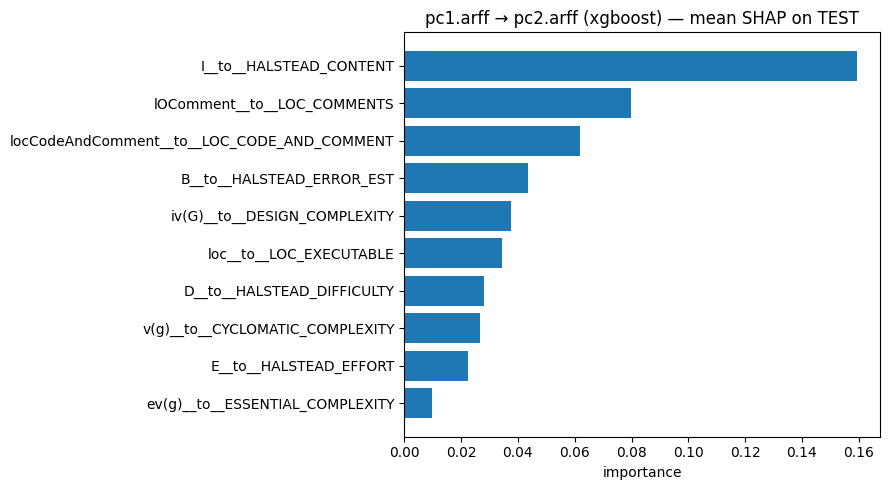

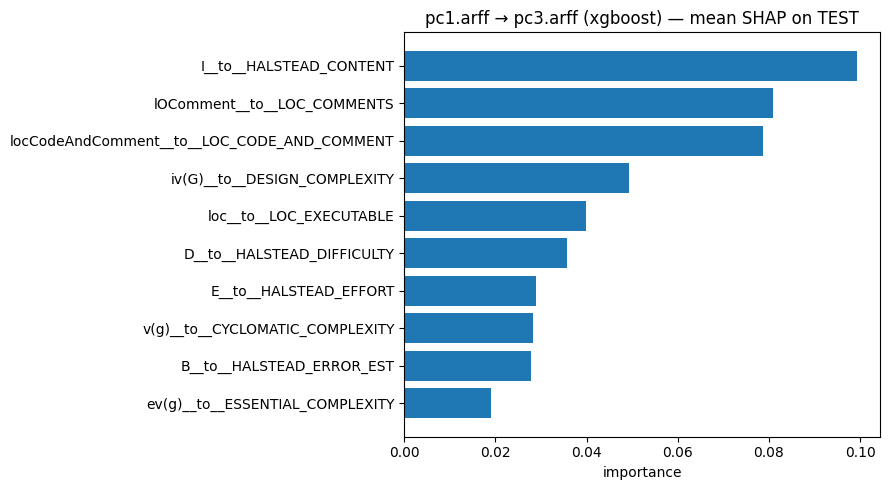

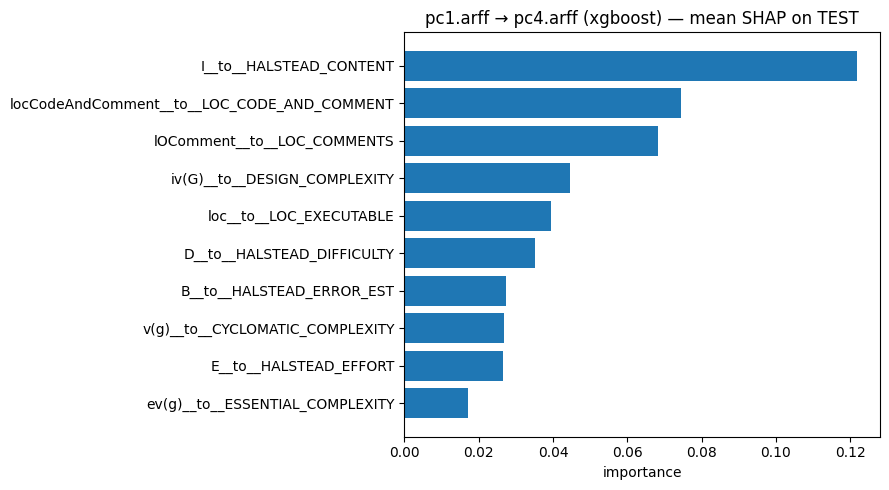

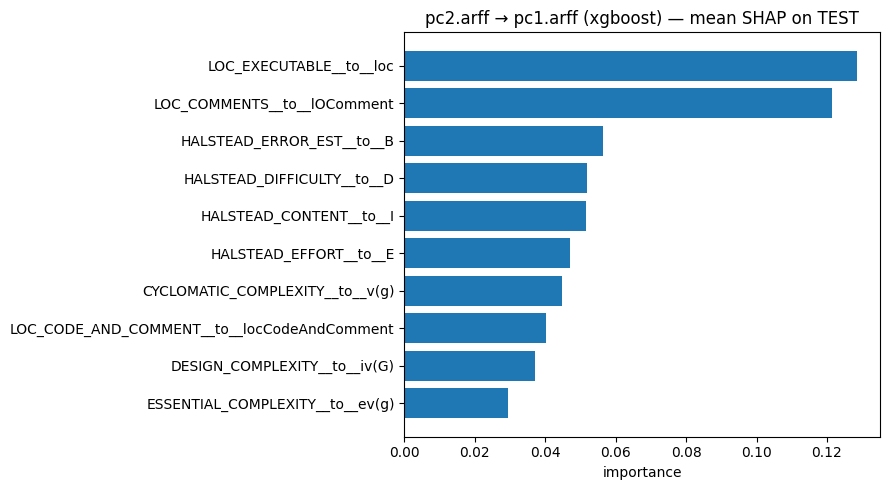

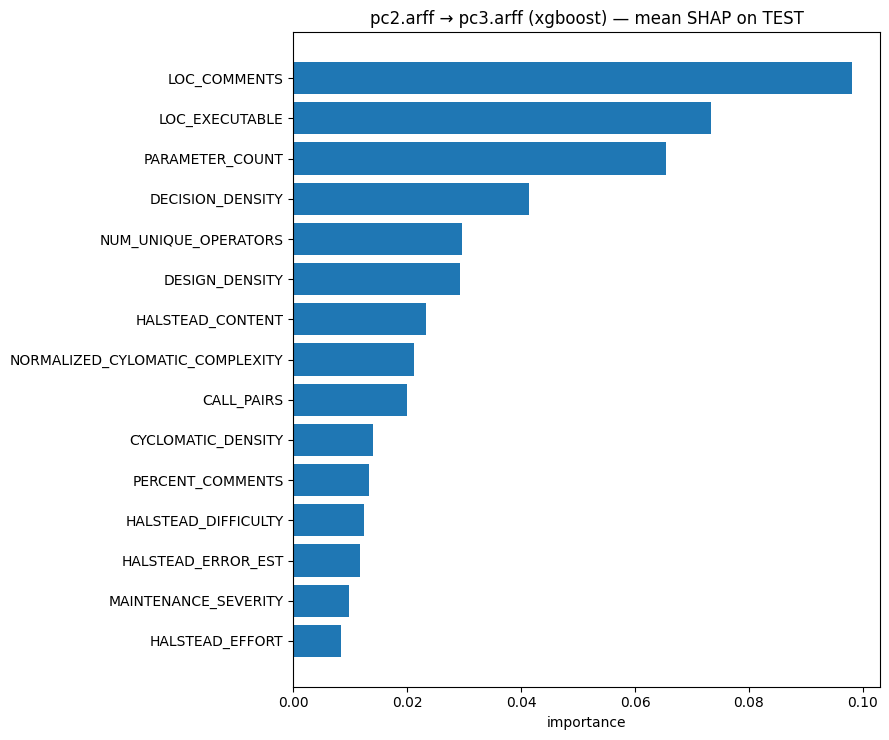

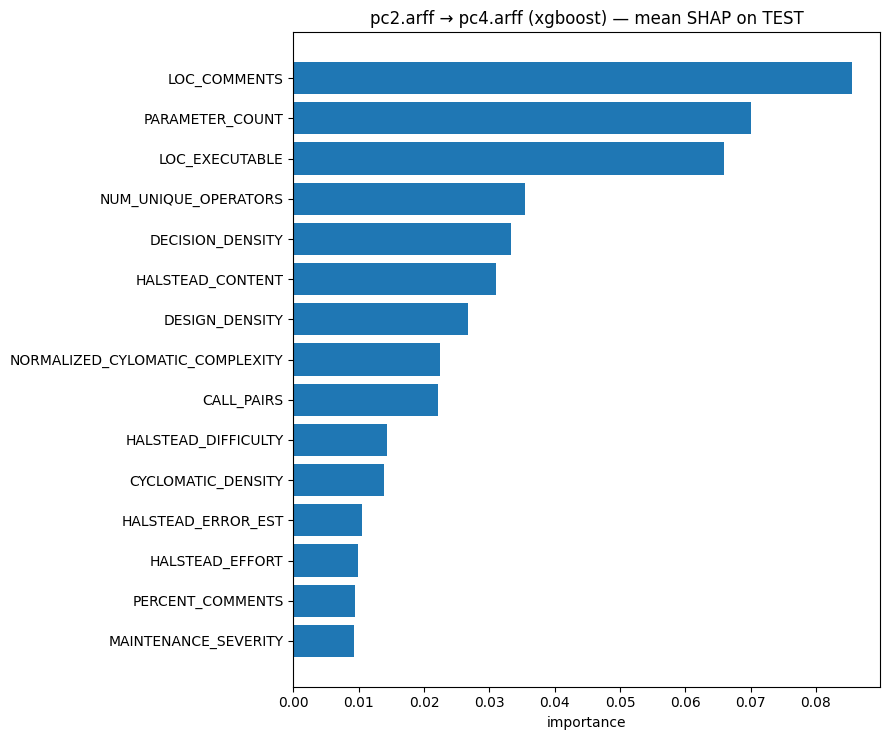

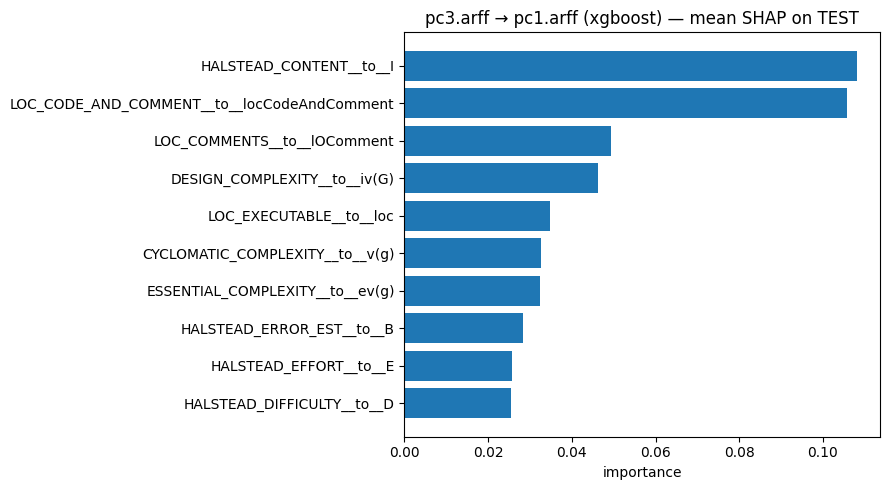

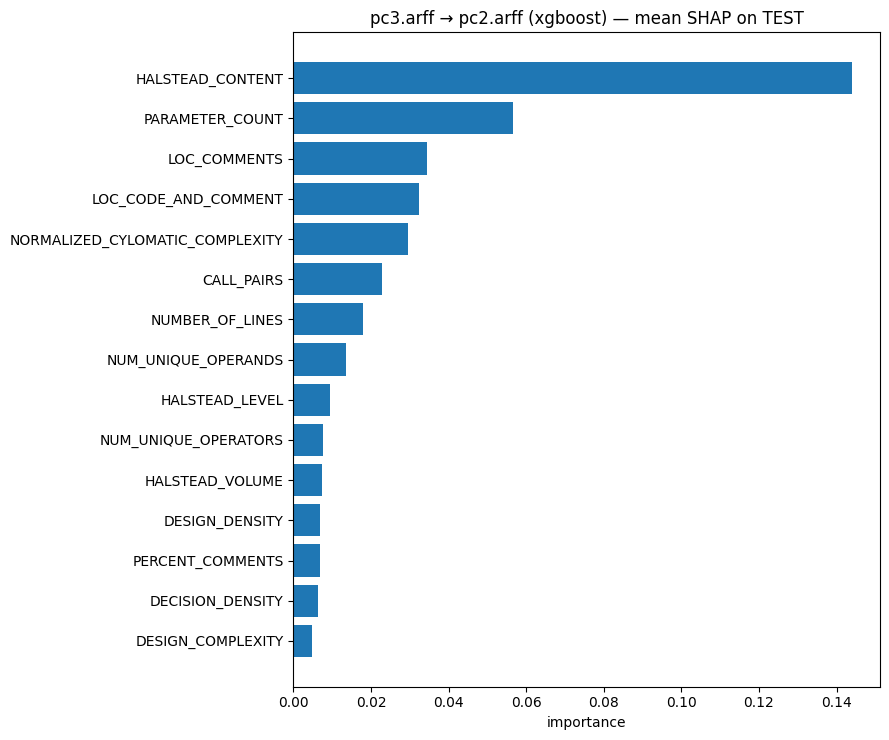

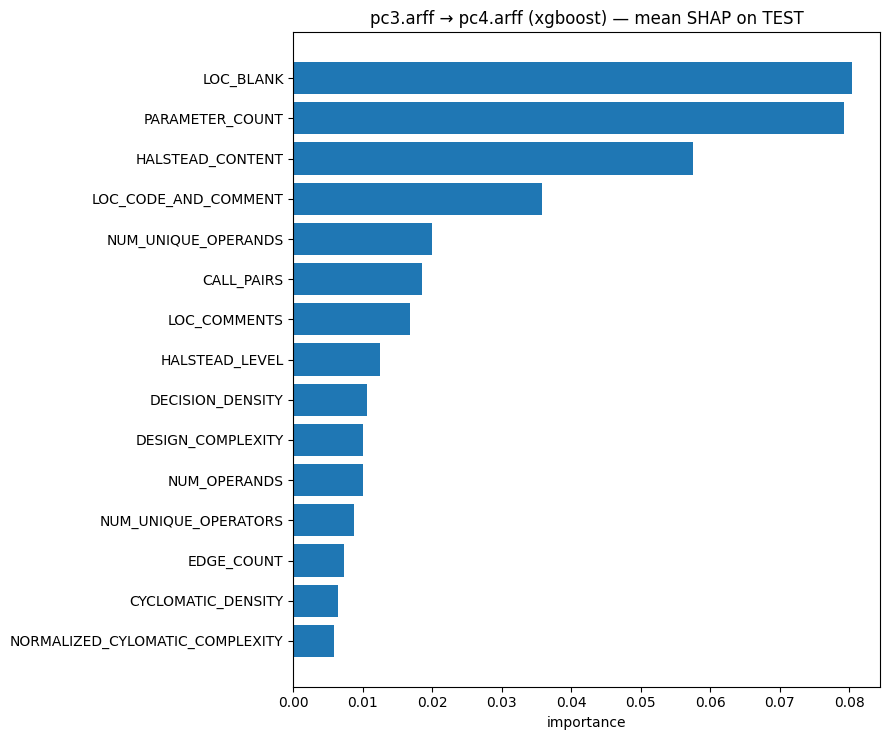

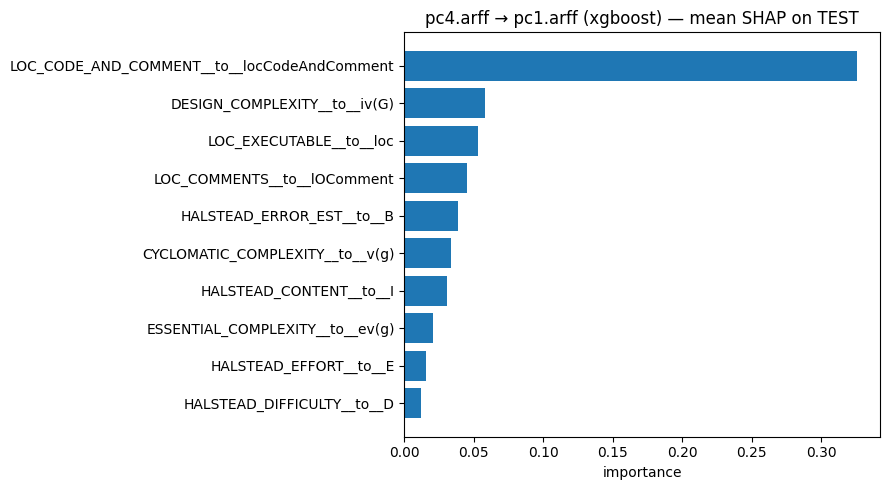

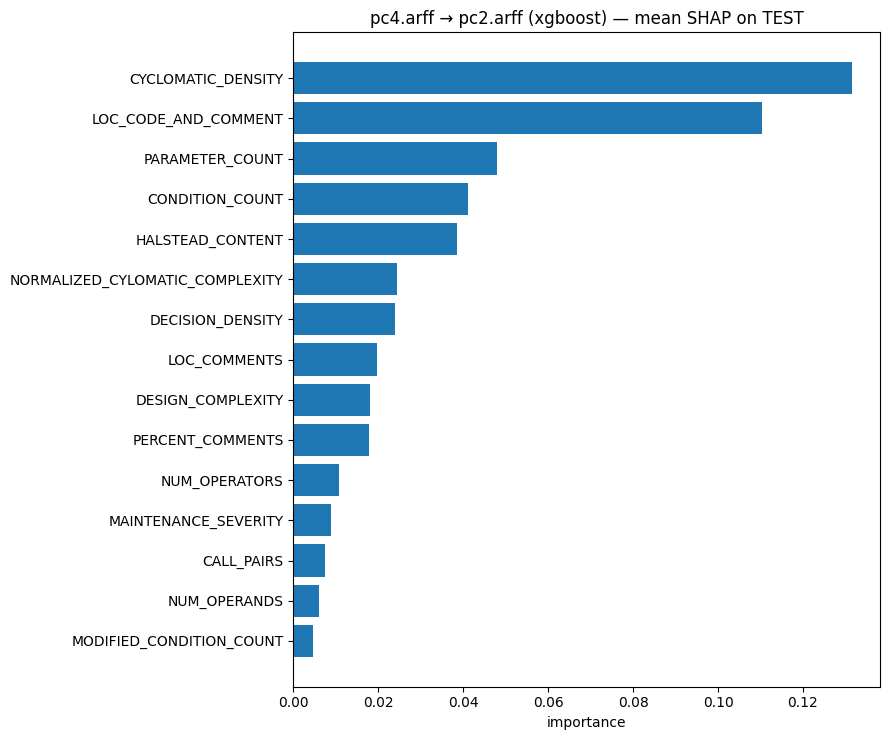

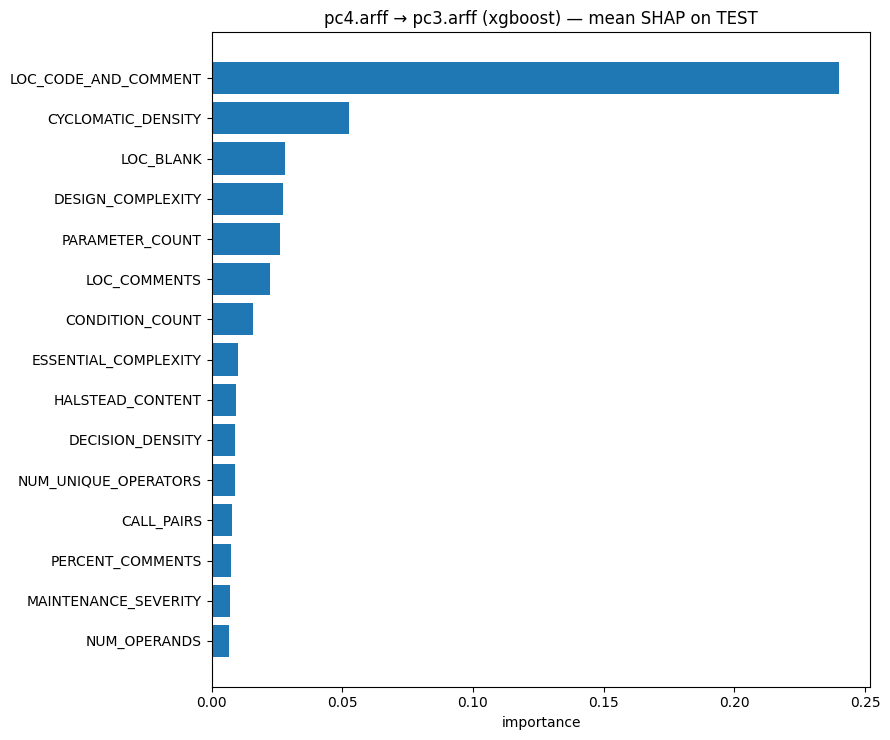

In [4]:
plot_all_zcross_pairs(
    zcross_artifacts=zcross_artifacts,
    pairs=SELECTED_PAIRS,
    top_k=15,
    model_name="xgboost"   # optional
)